## Plan-and-Exectute
1. User Request

2. Plan(Generate Tasks)

3. Execute Tasks(Single Task Agent)

4. Update State with Task Resuls

(a) Re-plan more tasks<br>

(b) Respond to User


ReAct style agent와 다른 점.
- 장기 계획 수립(long-term planning)
- 수행 단계에서 더 작은 모델 사용, 계획 단계에서만 큰 모델 사용.

In [1]:
from dotenv import load_dotenv
from langchain_teddynote import logging

logging.langsmith("LangGraph")
load_dotenv()

LangSmith 추적을 시작합니다.
[프로젝트명]
LangGraph


True

### Define Tools

In [2]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results = 3)]

In [4]:
tools[0].invoke("What's the weather in San Francisco?")

[{'url': 'https://www.weatherapi.com/',
  'content': "{'location': {'name': 'San Francisco', 'region': 'California', 'country': 'United States of America', 'lat': 37.775, 'lon': -122.4183, 'tz_id': 'America/Los_Angeles', 'localtime_epoch': 1731567048, 'localtime': '2024-11-13 22:50'}, 'current': {'last_updated_epoch': 1731566700, 'last_updated': '2024-11-13 22:45', 'temp_c': 13.9, 'temp_f': 57.0, 'is_day': 0, 'condition': {'text': 'Partly cloudy', 'icon': '//cdn.weatherapi.com/weather/64x64/night/116.png', 'code': 1003}, 'wind_mph': 5.1, 'wind_kph': 8.3, 'wind_degree': 205, 'wind_dir': 'SSW', 'pressure_mb': 1020.0, 'pressure_in': 30.13, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 77, 'cloud': 75, 'feelslike_c': 13.5, 'feelslike_f': 56.4, 'windchill_c': 12.9, 'windchill_f': 55.2, 'heatindex_c': 13.2, 'heatindex_f': 55.7, 'dewpoint_c': 12.5, 'dewpoint_f': 54.4, 'vis_km': 16.0, 'vis_miles': 9.0, 'uv': 0.0, 'gust_mph': 8.7, 'gust_kph': 14.0}}"},
 {'url': 'https://abc7news.com/post/weat

### Define Execution Agent

In [12]:
from langchain import hub
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

prompt = hub.pull("ih/ih-react-agent-executor")
prompt.pretty_print()

llm = ChatOpenAI(model = "gpt-4o-mini", temperature = 0)
agent_executor = create_react_agent(llm, tools, state_modifier = prompt)

================================ System Message ================================

You are a helpful assistant.

============================= Messages Placeholder =============================

{messages}


In [6]:
agent_executor.invoke({"messages": [("user", "2024년 노벨 문학상 시상자")]})

{'messages': [HumanMessage(content='2024년 노벨 문학상 시상자', additional_kwargs={}, response_metadata={}, id='382b11d9-cd8a-4068-b263-1d4ef3f72f35'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_qu0sgYm7F7eV98TJSKaW06UY', 'function': {'arguments': '{"query":"2024년 노벨 문학상 시상자"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 96, 'total_tokens': 124, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-de98b006-a1b2-427e-a1f9-41f0e8d119bf-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '2024년 노벨 문학상 시상자'}, 'id': 'call_qu0sgYm7F7eV98TJSKaW06UY', 'type':

### Define the State

1. input: string
2. current plan: list of strings
3. previous executed steps: list of tupels(step, result)
4. final response: string

In [51]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict


class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

### Planning Step

In [52]:
from pydantic import BaseModel, Field

class Plan(BaseModel):
    """Plan to follow in future."""
    steps: List[str] = Field(
        description = "different steps to follow, should be in sorted order"
    )

In [53]:
from langchain_core.prompts import ChatPromptTemplate

plan_prompt = ChatPromptTemplate.from_messages(
    [
        ("system",
        """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \ 
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps."""
        ),
        ("placeholder", "{messages}"),
    ]
)
planner = plan_prompt | ChatOpenAI(
    model = "gpt-4o-mini",
    temperature = 0
).with_structured_output(Plan)

In [54]:
result = planner.invoke({"messages": [("user", "2024년 노벨 문학상 시상자")]})
print(result)
print(result.steps[0])

steps=['2024년 노벨 문학상 시상일 확인', '2024년 노벨 문학상 후보자 발표 확인', '2024년 노벨 문학상 수상자 발표 확인', '2024년 노벨 문학상 수상자 이름 확인']
2024년 노벨 문학상 시상일 확인


### Re-Plan Step

In [55]:
from typing import Union


class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)


replanner = replanner_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(Act)

### Create the Graph

In [56]:
from typing import Literal
from langgraph.graph import END


async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }


async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return END
    else:
        return "agent"

In [61]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.add_edge(START, "planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
    ["agent", END],
)

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

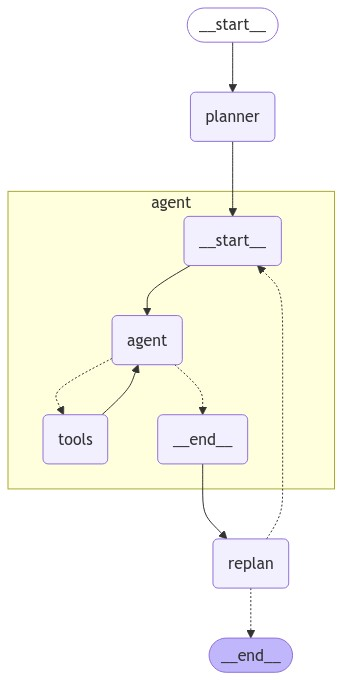

In [62]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [65]:
config = {"recursion_limit": 20}
inputs = {"input": "2024년 노벨 문학상 시상자가 누군지 한국어로 답변해줘"}

async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ['2024년 노벨 문학상 시상자에 대한 정보를 확인한다.', '2024년 노벨 문학상 시상자 발표일을 확인한다.', '발표된 시상자의 이름을 한국어로 정리한다.', '최종적으로 2024년 노벨 문학상 시상자를 한국어로 답변한다.']}
{'past_steps': [('2024년 노벨 문학상 시상자에 대한 정보를 확인한다.', '2024년 노벨 문학상 시상자는 한국 작가 한강입니다. 한강은 한국 작가 최초로 노벨 문학상을 수상하게 되었으며, 이는 한국인으로서는 두 번째 노벨상 수상입니다. 첫 번째는 2000년에 평화상을 수상한 고(故) 김대중 전 대통령입니다. \n\n한강 작가는 이로써 한국 문학의 위상을 높이는 쾌거를 이루었습니다.')]}
{'response': '2024년 노벨 문학상 시상자는 한국 작가 한강입니다. 한강은 한국 작가 최초로 노벨 문학상을 수상하게 되었으며, 이는 한국인으로서는 두 번째 노벨상 수상입니다. 첫 번째는 2000년에 평화상을 수상한 고(故) 김대중 전 대통령입니다. \n\n한강 작가는 이로써 한국 문학의 위상을 높이는 쾌거를 이루었습니다.'}
